Author: Abdulrahman Altahhan, 2025

The notebook uses a library of functionality in RL that aims for simplicity and general insight into how algorithms work, these libraries are written from scratch using standard Python libraries (numpy, matplotlib etc.).
Please note that you will need permission from the author to use the code for research, commercially or otherwise.

# Lesson 13: Action-Value Approximation and Policy Gradient Methods for Control 

**Learning outcomes**
1. understand how to generalize tabular control methods to function approximation methods
1. understand how to generalize tabular policy methods to policy approximation methods
1. understand how to using tile coding for a continuous control problem
1. understand the difference between additive and multiplicative representation
1. understand how to take advantage of binary representation to come up with a binary control algorithm-namely Binary Sarsa
1. understand the benefit of using hashing along the side with tile coding and the added benefit of using index hash table


**Reading**:
The accompanying reading of this lesson is **chapters 10 and 12** of our text book available online [here](http://incompleteideas.net/book/RLbook2020.pdf). Please note that we explain the ideas of this topic from a practical perspective and not from a theoretical perspective which is already covered in the textbook.

In this lesson, we continue our coverage of algorithms that use function approximation, this time for control. We use tile coding again, but this time in the context of an underpowered car that needs to climb a mountain. In susequent lessons, we then move to a set of powerful techniques that utilise the idea of eligibility traces, which allow an algorithm to perform updates that mimic the effect of a set of n-steps updates without having to wait for n-steps! We then move to cover RL algorithms that are suitable for Robotics and Games, which utilise non-linear function approximation, particularly neural networks shallow and deep, such as DQN and DDQN.

So far, we have not tackled any task that has a continuous state space; rather all the state spaces that we have come across were discrete. In this lesson, we will see how to apply the tile coding technique we covered in the previous lesson on a continuous *control* task. The task will be controlling an underpowered vehicle stuck between two hills. We want our car to successfully negotiate this terrain and reach the right hilltop. Along the way, we will develop a new binary algorithm, Binary Sarsa, that is suitable for dealing with binary encoding, and we will study its performance. We present three representations of the problem. The first just discretised the space and used a vector representation that corresponds with this discretisation. This representation is equivalent to using one tiling in tile coding. Then we develop this representation to use multiple tiling that offset each other to enrich the representation capability for our continuous space. We then try to reduce the extra overhead introduced by the tile coding using hashing. We show two types of hashing, one that uses raw hashing via the modulus % operator and one that uses an index hashing table, which guarantees correspondence with non-hashed tile coding when the table is large enough.
Ok let us get started...

In [1]:
%matplotlib inline

In [2]:
from rl.rlln import *
from math import floor

Note that we imported the Grid and the other environments from the Function approximation lesson because we are dealing with vectorised environment form now on.

# Control with Function approximation

## MDP with *Linear* Function Approximation
Below we show the implementation of the new MDP class. We have set it up in a way that allows us to maintain the same structure of the different updates that uses Q values. Note that we assign the new self.Q to the function self.Q_ which makes self.Q a function and then we can call self.Q(s,a) to obtain the Q values for state s and action a.

In [3]:
class vMDP(MDP(vMRP)):

    def init(self):
        super().init()
        self.W = np.ones((self.env.nA, self.env.nF))*self.q0
        self.Q = self.Q_

    def Q_(self, s=None, a=None):
        #print(s.shape)
        W = self.W if a is None else self.W[a]
        return W.dot(s) if s is not None else np.matmul(W, self.env.S_()).T 

    # we should have used ∇ but python does not like it
    def ΔQ(self,s): 
        return s

Below we make sure that the classes hierarchy is correct by double-checking that the policy of an MDP object is εgreedy.

In [4]:
vMDP().policy

<bound method MDP.<locals>.MDP.εgreedy of <__main__.vMDP object at 0x127e58b60>>

## Offline MCC with Any Function Approximation

In [5]:
class MCC(vMDP):
    
    def init(self):
        super().init()
        self.store = True
        
    # ---------------------------- 🌘 offline, MC learning: end-of-episode learning-----------------------    
    def offline(self):  
        # obtain the return for the latest episode
        Gt = 0
        for t in range(self.t, -1, -1):
            s = self.s[t]
            a = self.a[t]
            rn = self.r[t+1]
            
            Gt = self.γ*Gt + rn
            self.W[a] += self.α*(Gt - self.Q(s,a))*self.ΔQ(s)

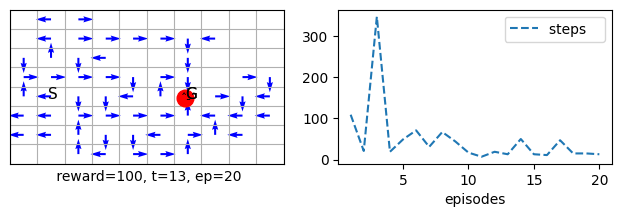

In [6]:
mc = MCC(env=vgrid(reward='reward100'), α=.5, episodes=20, seed=10, **demoQ()).interact()

## Online Sarsa with Any Function Approximation

In [7]:
class Sarsa(vMDP):

    def init(self): #α=.8
        super().init()
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t

    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        self.W[a] += self.α*(rn + (1-done)*self.γ*self.Q(sn,an) - self.Q(s,a))*self.ΔQ(s)
 

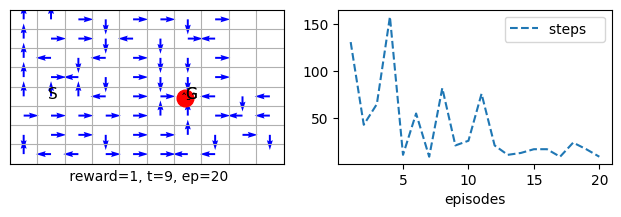

In [8]:
sarsa = Sarsa(env=vgrid(reward='reward1'), α=.8, episodes=20, seed=10, **demoQ()).interact()

In [9]:
sarsa.Q_(10,1)

array([-32.256     , -33.9072    , -27.2128    , -24.5888    ,
       -16.32      ,  -8.        ,  -8.        ,   0.        ,
         0.        ,   0.        , -41.189888  , -33.6       ,
       -27.4432    , -24.64      , -17.6       ,  -9.6       ,
        -8.        ,  -8.        ,   0.        ,  -8.        ,
       -39.7592576 , -35.354112  , -29.29706435, -19.989784  ,
        -9.99998879,  -0.32      ,   0.        ,   0.        ,
         0.        ,   0.        , -41.7846272 , -46.20985139,
       -27.0091264 , -24.335872  , -16.144384  ,  10.        ,
         0.        ,  -8.        ,  -8.        ,  -8.        ,
       -39.0272    , -37.9008    , -24.256     , -18.88      ,
       -11.586048  ,  -9.6       ,  -8.        ,   0.        ,
         0.        ,   0.        , -33.28      , -32.83456   ,
       -28.46976   , -24.97024   , -20.1728    , -11.2       ,
        -8.        ,   0.        ,   0.        ,   0.        ,
       -34.0992    , -26.6368    , -22.976     , -24.51

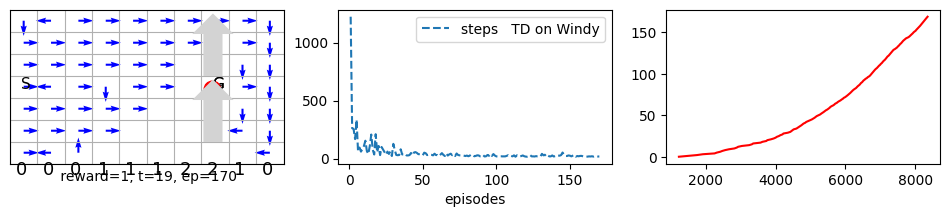

In [10]:
def example_6_5():
    return Sarsa(env=vwindy(reward='reward1'), α=.5, episodes=170, seed=100, **demoQ()).interact(label='TD on Windy')
    
trainedV = example_6_5()

plt.subplot(133).plot(trainedV.Ts.cumsum(), range(trainedV.episodes),'-r', label='cumulative steps')
plt.show()

## Q-learning with Function Approximation

In [11]:
class Qlearn(vMDP):
# 🕹️ 𖡄 
    #--------------------------------------🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):
        self.W[a] += self.α*(rn + (1-done)*self.γ*self.Q(sn).max() - self.Q(s,a))*self.ΔQ(s)

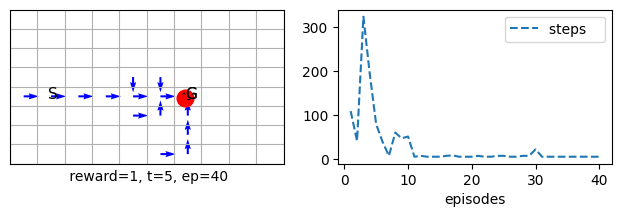

In [12]:
qlearn = Qlearn(env=vgrid(), α=.8, γ=1, episodes=40, seed=10, **demoQ()).interact()

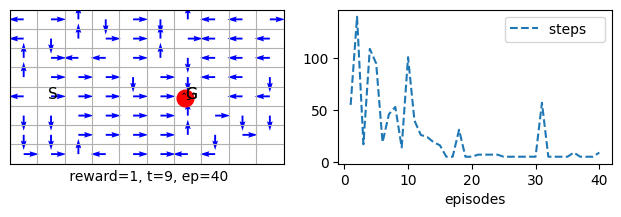

In [13]:
qlearn = Qlearn(env=vgrid(reward='reward1'), γ=1, α=.8, episodes=40, seed=10, **demoQ()).interact()

## Sarsa and Q-Learning on the Cliff!

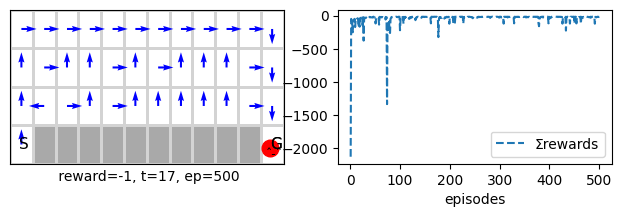

In [14]:
sarsa = Sarsa(env=vcliffwalk(), α=.5, episodes=500, seed=10, **demoR()).interact()

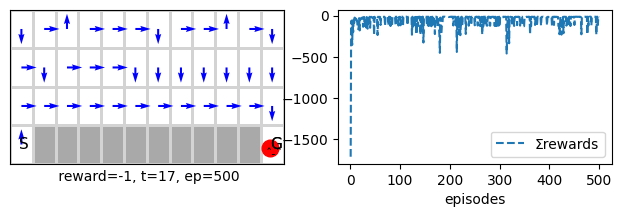

In [15]:
sarsa = Qlearn(env=vcliffwalk(), α=.5, episodes=500, seed=10, **demoR()).interact()

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


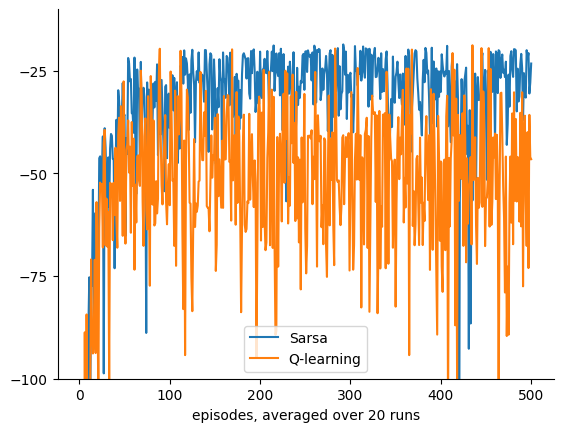

In [16]:
SarsaCliff, QlearnCliff = example_6_6(runs=20, env=vcliffwalk(), alg1=Sarsa, alg2=Qlearn)# runs=500

In [17]:
class XSarsa(vMDP):

    # ------------------------------------- 🌖 online learning --------------------------------------
    def online(self, s, rn,sn, done, a,_):      
        # obtain the ε-greedy policy probabilities, then obtain the expecation via a dot product for efficiency
        π = self.π(sn)
        v = self.Q(sn).dot(π)
        self.W[a] += self.α*(rn + (1-done)*self.γ*v - self.Q(s,a))*self.ΔQ(s)

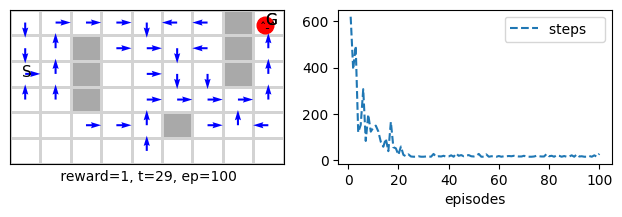

In [18]:
xsarsa = XSarsa(env=vmaze(), α=.5, γ=1, episodes=100, seed=1, **demoQ()).interact()

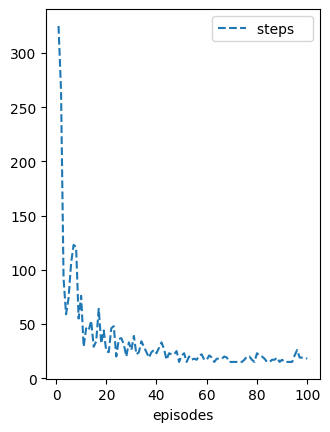

In [19]:
xsarsa = XSarsa(env=vcliffwalk(), α=.5, γ=1, episodes=100, seed=1, plotT=True).interact()

##  One-hot-encoding with redundant features for control

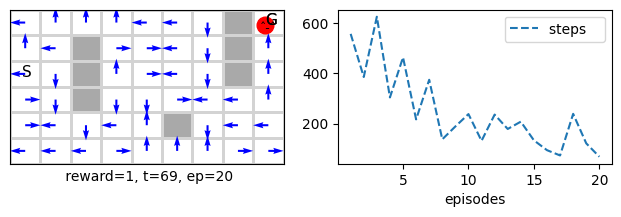

In [20]:
sarsa = Sarsa(env=vmaze(nF=160, reward='reward1'), episodes=20, seed=10, **demoQ()).interact()

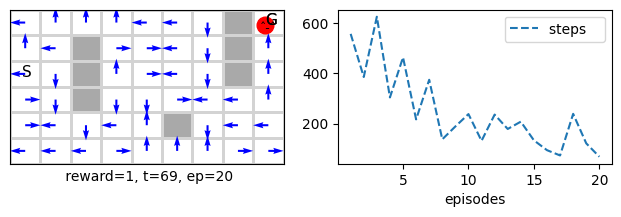

In [21]:
sarsa.store=True
sarsa.interact(seed=10)

In [22]:
sarsa.s[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint32)

Note how we have almost 100 extra redundant features that will never be turned on. The point of doing such thing is to double check that our infrastructure is capable of accommodating different features sizes and is not tied to a feature representation that has the same size of the state space.

## Policy Gradient Methods with Function Approximation

We turn out attention now to develop an actor-critic algorithm that uses function approximation. Note that as we said earlier the actor part uses control updates similar to Sarsa or Q learning while the critic part uses TD prediction updates. Hence, writing our algorithm is straightforward because we have already developed the infra-structure for both prediction and control.

Note that if you have not read the policy gradient methods in lesson 4 and 5. It is now time to go back and read the corresponding sections. The ideas of policy gradient method are covered in chapter 13 of our book.

In [23]:
class Actor_Critic(PG(vMDP)):

    def step0(self):
        self.γt = 1 # powers of γ
        
    # -------------------------------------- 🌖 online learning ------------------------------
    def online(self, s, rn,sn, done, a,_): 
        π, γ, γt, α, τ, t, ΔV, ΔQ = self.π, self.γ, self.γt, self.α, self.τ, self.t, self.ΔV, self.ΔQ
        
        δ = (1- done)*γ*self.V(sn) + rn - self.V(s)    # TD error is based on the critic estimate
        
        self.w    += α*δ*ΔV(s)                         # critic v
        self.W[a] += α*δ*ΔQ(s)*(1 - π(s,a))*γt/τ       # actor  
        self.γt *= γ  
        

Note that since we use a separate $\theta_a$ for each action, where we have that 

$Q(s,a) = \phi^\top \theta_a \qquad$ 
$\pi(a|s,\theta_a) = \frac{e^{\phi^\top \theta_a}}{\sum_{b}{e^{\phi^\top \theta_b}}}$


then equation 13.9 becomes as follows

$\nabla_{\theta_a} ln \pi(a|s,\theta_a) = \phi (1-  \pi(a))$

In the book authors assumes that we are using a concatenated vector $\theta$ for all actions where each n weights represents one of the actions.

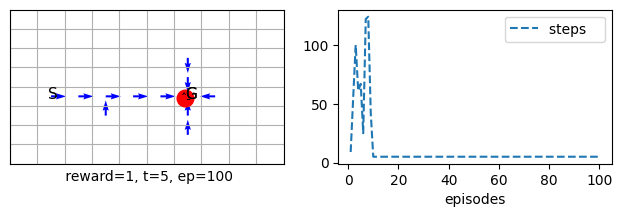

In [24]:
ac = Actor_Critic(env=vgrid(), α=1, τ=.1, γ=1, episodes=100, seed=0 , **demoQ()).interact()

In the below (disabled cell) we can see that the agent arrives at a good policy but it takes long to reach the goal. The reason is because the action-values differences is not high enough to converge to a close to greedy policy. Enable the cell by pressing escape then y and run the cell to see the lengthy run despite an apparent and sound policy shown by the arrows.

ac = Actor_Critic(env=vmaze(), α=.1, γ=.98, episodes=30, seed=0 , **demoQ()).interact()

Below we solve the problem by decaying the exploration rate τ exponentially.

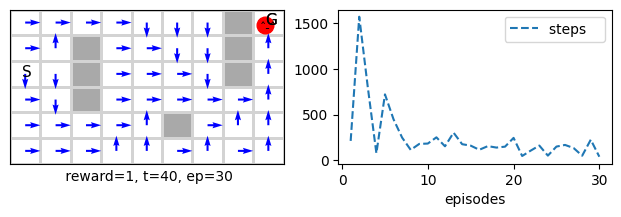

In [25]:
ac = Actor_Critic(env=vmaze(), α=.1, τmin=.05, dτ=.5,  γ=1, episodes=30, seed=0 , **demoQ()).interact()

In [26]:
ac.τ

0.05

we can also decay linearly τ as follows

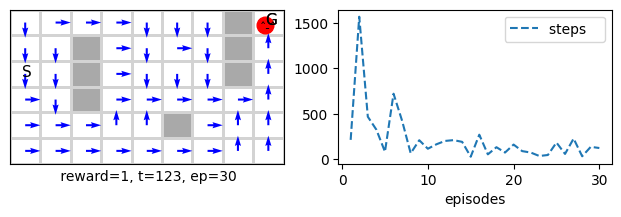

In [27]:
ac = Actor_Critic(env=vmaze(), α=.1, τmin=.01, Tτ=500,  γ=1, episodes=30, seed=0 , **demoQ()).interact()

In [28]:
ac.τ

0.01

However we can achieve a better results by using a combination of intermediate reward and higher learning rate. Let us start by setting a different reward.


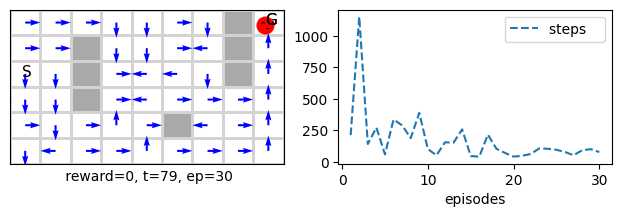

In [29]:
ac = Actor_Critic(env=vmaze(reward='reward0'), α=.1, τ=1,  γ=1, episodes=30, seed=0 , **demoQ()).interact()

Now let us increase the learning rate.

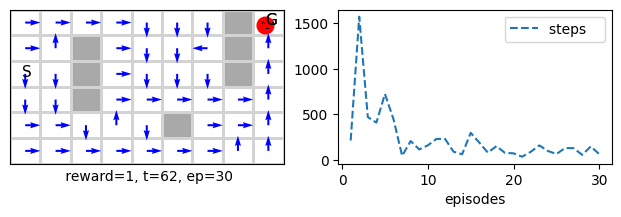

In [30]:
ac = Actor_Critic(env=vmaze(), α=.8, τ=1,  γ=1, episodes=30, seed=0 , **demoQ()).interact()

Now let us do both

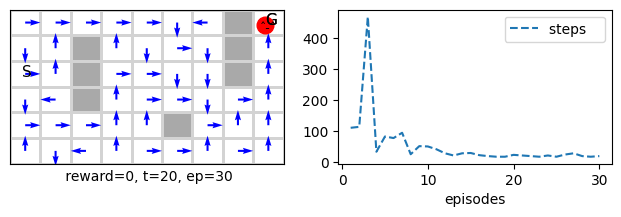

In [31]:
ac = Actor_Critic(env=vmaze(reward='reward0'), α=.8, τ=1,  γ=1, episodes=30, seed=0 , **demoQ()).interact()

When we increase exploration for this setting we get 

# Mountain Car Problem

We tackle the mountain car problem. This is problem is continuous and attention is needed for the way we represent the states. It has a boundaries for the x position as [-1.2,  .5]. In order to deal with it we need to discretize the X space by dividing it into a number of intervals each has a size of ω.

## Continuous Problem and State Space Discretisation
Below we show how we can discretise the problem by rescaling its range. We show the boundaries as well as some intermediate x positions. Note that we have always nS-2 as the max of the discretized s where the goal location is.

In [32]:
def ind(x=.1, printX=False):
    X0, Xn  = -1.2, .5 
    ntiles = 16
    nS = ntiles +1
    X = np.linspace(X0, Xn, ntiles)
    scX = (ntiles)/(Xn - X0) # scaled range
    
    s = int(scX*(x - X0)) 
    
    if printX: print(np.round(X,2))
    print('at x=%.2f we have, s=%d:'%(x,s))
    print()

ind(x=-1.2, printX=True)  # boundary case: far left
ind(x=.5)                 # boundary case: far right
ind(x=.5-.001)             # boundary case: far right
ind(x=.1)                 # mid state


[-1.2  -1.09 -0.97 -0.86 -0.75 -0.63 -0.52 -0.41 -0.29 -0.18 -0.07  0.05
  0.16  0.27  0.39  0.5 ]
at x=-1.20 we have, s=0:

at x=0.50 we have, s=16:

at x=0.50 we have, s=15:

at x=0.10 we have, s=12:



Note how the index for the far end ==ntiles which means that the number of states is actually ntiles+1.

## Additive State Space
We have two continuous spaces that specify the position and the velocity state of our car so we need to find a way to combine the two discretised spaces. We start by developing a form of binary encoding that is additive. We will call the set of partitions’ tiles to help the consistency of the cover. But bear in mind that additive spaces are not called tilings.
This will help us gradually move towards tile coding to appreciate its work and why.
Below is the code for animating and dealing with this problem. We have used an additive state space. So, we have concatenated the discrete representation of the position (nS) with the discrete representation for the velocity(ntiles) to make up one vector for representing the position and the velocity of the car where the vector has a size of nS+ntiles.

Ok let us get started...

In [33]:
print(floor(9.5/3.1))
print(9.5//3.1)

3
3.0


In [50]:
class MountainCar:
    def __init__(self, ntiles=8,  **kw):   # ntiles: number of tiles 
        # constants                          
        self.X0,  self.Xn  = -1.2, .5       # position range
        self.Xv0, self.Xvn = -.07, .07      # velocity range
        self.η = 3                          # we rescale by 3 to get the wavy valley/hill

        # for render()
        self.X  = np.linspace(self.X0,  self.Xn, 100)     # car's position
        self.Xv = np.linspace(self.Xv0, self.Xvn, 100)    # car's speed
        self.Y  = np.sin(self.X*self.η)
        
        # for state encoding (indexes)
        self.ntiles  = ntiles
        # number of states is nS*nSd but number of features is nS+nSd with an econdoing power of 2^(nS+nSd)>>nS*nSd!
        self.nF = self.nS = 2*(self.ntiles+1)

        self.nA = 3
        # for compatability
        self.Vstar = None
        self.nsubplots=3
        
        # reset
        self.x  = -.6 + rand()*(-.4+.6)
        self.xv = 0

        # figure setup
        self.figsize0 = (12, 2) # figsize0 is used for compatibility
        
      
    # get the descritized position and velocity
    def s(self, tilings=1):
        return floor(tilings*self.ntiles*(self.x  - self.X0 )/(self.Xn  - self.X0 ))
    
    def sv(self, tilings=1):
        return floor(tilings*self.ntiles*(self.xv - self.Xv0)/(self.Xvn - self.Xv0))
        
    def reset(self):
        #self.goals = self.nF -1 # to make sure that it is updated if we update nF
        self.x  = -.6 + rand()*(-.4+.6)
        self.xv = 0
        return self.s_()
        
    
    def s_(self):       
        φ = np.zeros(self.nF) 
        φ[self.s()] = 1 
        φ[self.sv() + self.ntiles + 1] = 1 
        return φ

    # for compatibility
    def S_(self):
        return np.eye(self.nF)
    
    def isatgoal(self):
        return self.x==self.Xn
    
    def step(self,a):
        a-=1       # to map from 0,1,2 to -1,0,+1
        self.xv += .001*a - .0025*np.cos(self.η*self.x); self.xv = max(min(self.xv, self.Xvn), self.Xv0)
        self.x  += self.xv;                              self.x  = max(min(self.x,  self.Xn ), self.X0 )
        
        # reset speed to 0 when reaching far left
        if self.x<=self.X0:  self.xv = 0
        
        return self.s_(), -1.0, self.isatgoal(), {}


    def render(self,  visible=True, pause=0, subplot=131, animate=True, **kw):
        if not visible: return
        
        self.ax0 = plt.subplot(subplot)
        plt.gcf().set_size_inches(self.figsize0[0], self.figsize0[1])
        
        car = '\ō͡≡o˞̶' # fastemoji
        bbox = {'fc': '1','pad': -5}
        
        X = self.X
        Y = self.Y
        η = self.η
        
        plt.plot(X+.1,Y, 'k')
        plt.plot(X[-1]+.1,Y[-1]-.05,'sg')
        plt.text(X[-1],Y[-1]+.2,'Goal', color='g', size=14)
        plt.title('Mountain Car', size=20)
        plt.axis("off")
        
        # plot the mountain car 
        # take the derivative of the terrain to know the rotation of the car to make it more realistic
        rotation = np.arctan(np.cos(self.x*η))*90  
        plt.text(self.x, np.sin(self.x*η)+.05, car, va='center', rotation=rotation,  size=13, fontweight='bold', bbox=bbox)

        if animate: clear_output(wait=True); plt.show(); time.sleep(pause)

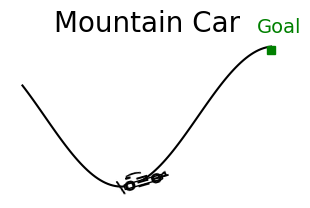

In [51]:
mcar = MountainCar()
mcar.render()

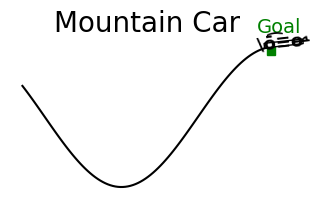

In [52]:
mcar = MountainCar()
mcar.x  = mcar.X0
mcar.xd = 0

while not mcar.isatgoal():
    mcar.step(2)
    mcar.render()
    #print(np.sin(mcar.x))

In [53]:
mcar.xd

0

## Studying the behaviour of the car
Let us see how the car behaves if we do not accelerated forward throttle=0, the car would depend on it mass and the inclination of the terrain and it would keep oscillating backwards and forward.

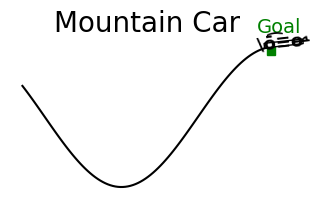

In [54]:
mcar.x  = mcar.X0
mcar.xd = 0

for _ in range(200):
    mcar.step(1)
    mcar.render()

The above was for starting on top of the left hill, but this is not the starting position of the car. The car always start at the bottom of the valley. Let us see how the car behaves if we just accelerated forward throttle=+1 when we start at the bottom of the valley.

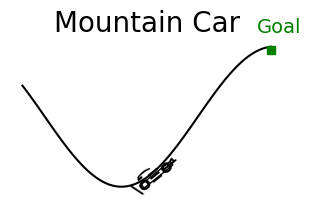

In [55]:
mcar.reset()
for _ in range(200):
    mcar.step(2)
    mcar.render()

Let us see how the car behaves when we start at the top of the right hill and when we just accelerated backwards throttle=-1.

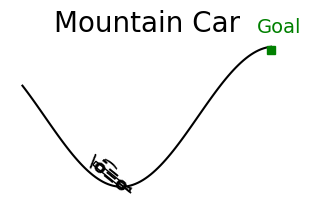

In [56]:
mcar.x  = mcar.X[-2]
mcar.xd = -1

for _ in range(200):
    mcar.step(0)
    mcar.render()


## Optimal solution
Obviously the optimal policy would be to accelerate forward and then backward to gain momentum to be able to reach the top since the car has not enough engine power to reach it by simple forward acceleration.


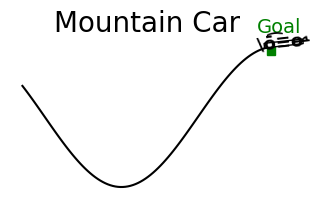

In [57]:
mcar.reset()

# swing forward and backward to gain momentum and then go full speed on
swing=24 # try 22 or less to see what happen
# 1. accelerate forward  
for _ in range(swing):
    mcar.step(2)
    mcar.render()
    
# 2. accelerate backward to take advantage from the momentum
for _ in range(swing):
    mcar.step(0)
    mcar.render()

# 3. now full throttle forward to reach the goal
for _ in range(100):
    mcar.step(2)
    mcar.render()

## Optimal Policy
As we can see, the car must intelligently swing itself forward and then backwards before reaching the top. This kind of problem is hard to find a policy for using traditional control algorithms because things need to get worse (away from the goals) before getting better. The credit assignment plays on the long run rather than on immediate improvements.

**Note** that in all what will come below, we set the learning rate to be α=()/8 because the default number of tiles is 8. Please differentiate between this and the number of tilings which we will vary, but it will also be set to 8.

Ok let us start training

### Short number of episodes

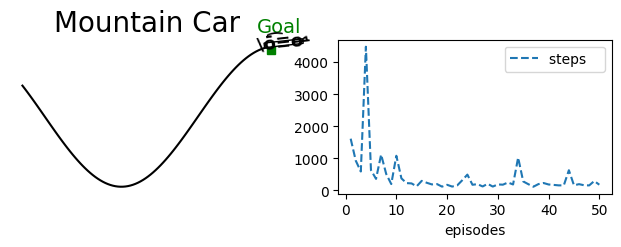

In [58]:
sarsa = Sarsa(env=MountainCar(), α=.5/8, ε=0.1, episodes=50, seed=1, **demoQ()).interact()

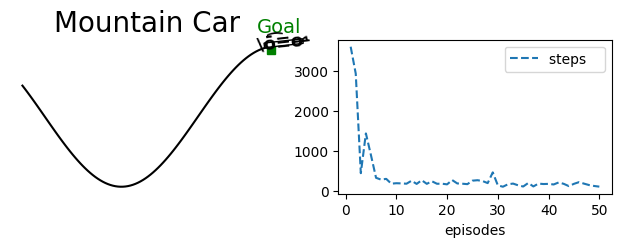

In [59]:
qlearn = Qlearn(env=MountainCar(), α=.5/8, ε=0.1, episodes=50, seed=1, **demoQ()).interact()

Longer episodes

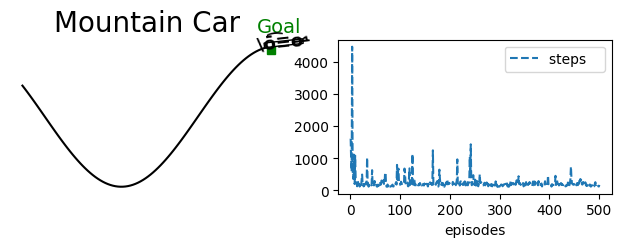

In [60]:
sarsa = Sarsa(env=MountainCar(), α=.5/8,  ε=0.1, episodes=500, seed=1, **demoQ()).interact()

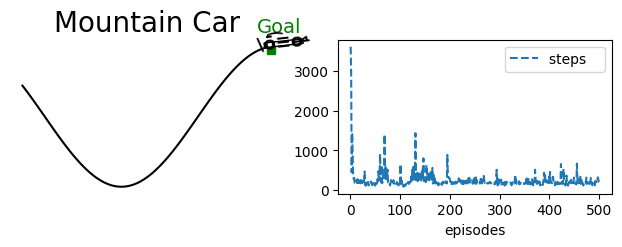

In [61]:
qlearn = Qlearn(env=MountainCar(), α=.5/8, ε=0.1, episodes=500, seed=1, **demoQ()).interact()

Note that there is uncontrollable element of randomness due to the random starting position of the car that is part of the hardness of the problem. So each time you run even with the same seed you will get a different learning curve.

### Exploration by optimistic initialisation
We use a reward scheme of -1 in every step with an initial value function of 0. These initial values are optimistic, given that the agent will be punished for every step before reaching the goal. Such settings naturally encourage the agent to explore the early episodes because it will be disappointed by the reward that it gets, so we do not need to adopt an exploratory policy explicitly, and we can set ε=0. Let us see how the Sarsa act on such a purely greedy policy with optimistic initialisation to encourage exploration.


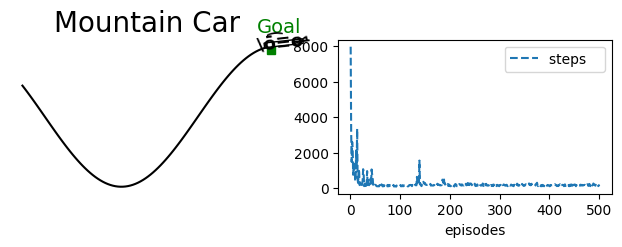

In [62]:
sarsa = Sarsa(env=MountainCar(), α=.1/8,   ε=0,  episodes=500, seed=1, **demoQ()).interact()

## Sarsa for Binary Encoding
Let us make our Sarsa implementation more efficient for a binary encoding where each component in the state vector is either 0 or 1. This simplifies the implementation of the dot product to be turned into summation. below we show the implementation.

In [63]:
s = np.array([0, 2 ,0, 1, 0])
# s = np.array([0, 0 , 0, 0, 0])
W = np.array([[.1,.2 ,.3, .4, .5], [1,2 ,3, 4, 5]])
S = np.where(s!=0)[0]
print(len(S))
for i in S:
    print(i)

print(W[0,np.where(s!=0)[0]].sum(0).round(2))
print(W[1,np.where(s!=0)[0]].sum(0).round(2))

print(W[:,np.where(s!=0)[0]].sum(1))

2
1
3
0.6
6.0
[0.6 6. ]


In [64]:
class SarsaB(vMDP):  # Binary Sarsa that deals with binary state representation (later will have multiple tilings so we would have more than one hot encoding but each tilings is a one-hot encoding)

    def init(self):
        super().init() # α=.8
        self.store = False       
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    def Q_(self, s=None, a=None):
        if s is None: return np.matmul(self.W, self.S).T 
        s_ = np.where(s!=0)[0] # set of indexes that represents states because we use a binary representation
        Q = self.W[:,s_].sum(1) if a is None else self.W[a,s_].sum(0)
        return Q if Q.size else 0
    
    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        s_ = np.where(s!=0)[0]
        self.W[a,s_] += self.α*(rn + (1-done)*self.γ*self.Q(sn,an) - self.Q(s,a))


## Runs on Mountain Car
Let us now see the Sarsa behaviour on several runs

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
CPU times: user 32.7 s, sys: 77.5 ms, total: 32.8 s
Wall time: 32.8 s


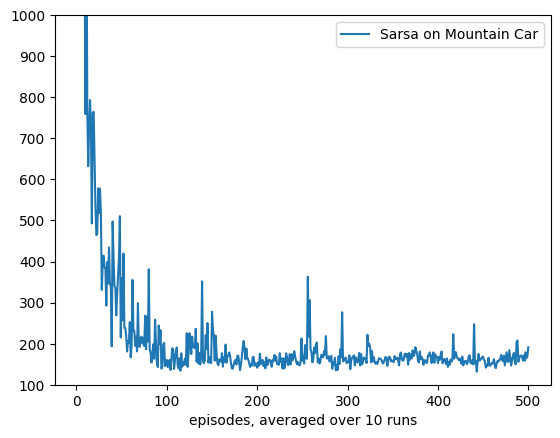

In [65]:
plt.ylim(100,1000)
%time sarsaRuns = Runs(algorithm=Sarsa(env=MountainCar(),α=.1/8, episodes=500, ε=0),\
                       runs=10, seed=1, plotT=True).interact(label='Sarsa on Mountain Car')

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
CPU times: user 1min 8s, sys: 843 ms, total: 1min 9s
Wall time: 1min 9s


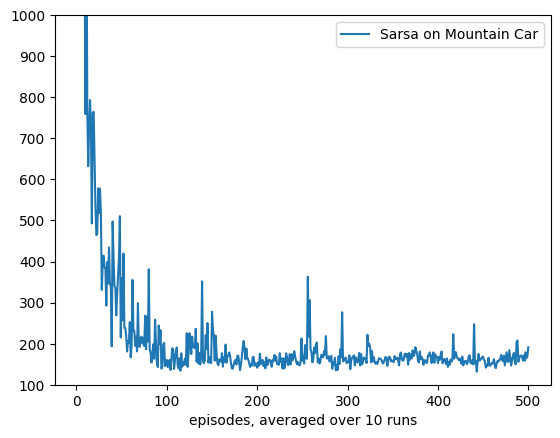

In [66]:
plt.ylim(100,1000)
%time sarsaRuns = Runs(algorithm=SarsaB(env=MountainCar(), α=.1/8, episodes=500, ε=0),\
                       runs=10, seed=1, plotT=True).interact(label='Sarsa on Mountain Car')

As we can see both runs plots are identical as expected. However, Sarsa is faster than the Binary Sarsa. The reason is as usual the dot product is highly optimised and unless we are dealing with a very large state space the usual Sarsa is more efficient.

## Binary Mountain Car Class and Binary Sarsa
If we guarantee that we send indices instead of a feature vector we might be able to reduce the overhead. Let us see how.

In [67]:
class SarsaB(vMDP):  # Binary Sarsa that deals with binary state representation (later will have multiple tilings so we would have more than one hot encoding but each tilings is a one-hot encoding)

    def init(self):
        super().init() # α=.8
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t
    
    def Q_(self, s=None, a=None):
        if s is None: return np.matmul(self.W, self.S).T 
        Q = self.W[:,s].sum(1) if a is None else self.W[a,s].sum(0)
        return Q if Q.size else 0

    # ----------------------------------------🌖 online learning ----------------------------------------
    def online(self, s, rn,sn, done, a,an):
        self.W[a,s] += self.α*(rn + (1-done)*self.γ*self.Q(sn,an) - self.Q(s,a))


As we can see we got rid of the s_ = np.where(s!=0)[0] statement in both the Q_() and online() functions. This statements obtain the indexes of the features that are on. To guarantee that s contain the indexes we need to adjust the environment as follows.

In [68]:
class MountainCarB(MountainCar):
    def __init__(self, **kw):
        super().__init__(**kw)

    def s_(self):
        return [self.s(), self.sv()+ self.ntiles + 1]


Now let us run the same experiments on the new two classes MountainCarB and SarsaB.

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
CPU times: user 1min, sys: 550 ms, total: 1min 1s
Wall time: 1min 1s


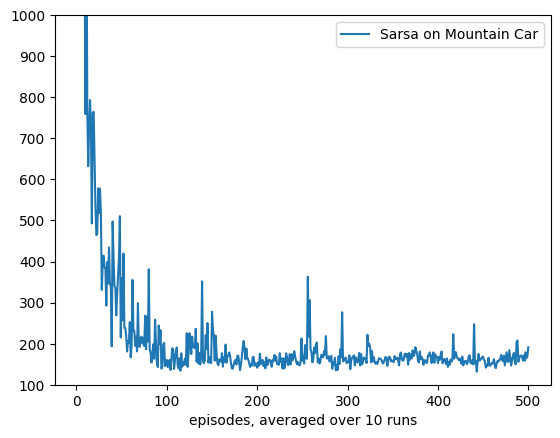

In [69]:
plt.ylim(100,1000)
%time sarsaRuns = Runs(algorithm=SarsaB(env=MountainCarB(), α=.1/8, episodes=500, ε=0),\
                       runs=10, seed=1, plotT=True).interact(label='Sarsa on Mountain Car')

## Mountain Car Runs
Let us now develop a function to conduct several runs on the mountain car problem to see how the different state representations perform with different learning rates.

In [70]:
def MountainCarRuns(runs=20, algo=Sarsa, env=MountainCar(), label='', ε=0):
    for α in [.1, .2, .5]:
        sarsaRuns = Runs(algorithm=algo(env=env, α=α/8, episodes=500, ε=ε),
                         runs=runs, seed=1, plotT=True).interact(label='α=%.2f/8'%α)
    plt.ylim((10**2,10**3))
    plt.yscale('log')
    plt.title('Semi Gradient ' + algo.__name__  +' on Mountain Car '+label)
    
fig_10_2 = MountainCarRuns

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
CPU times: user 2min 49s, sys: 470 ms, total: 2min 49s
Wall time: 2min 50s


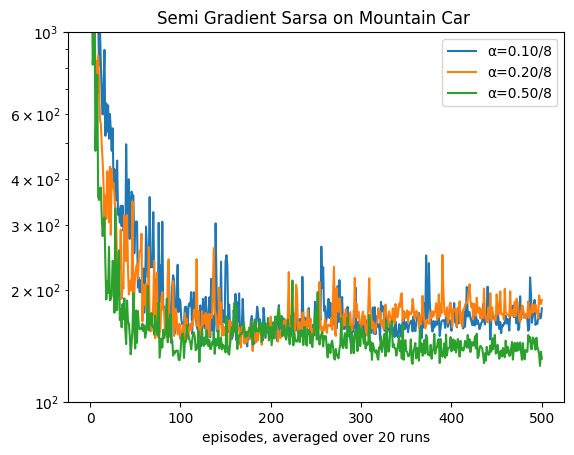

In [71]:
%time MountainCarRuns()

As we can see, the algorithm shows some signs of underperformance and instability. This is a common problem when we have less representational capabilities in our state space due to the additivity nature of our space.

The adopted additive representation is ok, but it has its limitations. The main issue is that the total number of possible states is $ntiles \times ntiles$, but the dimensionality of our vector is far less than that it is ntiles+ntiles. It is not a one-hot encoding, so each component does not correspond to one state. Instead, two components correspond to one state. These two issues combined reduced the capability of our algorithms to generalise to nearby states.

## Multiplicative State Space: Tile Coding for Mountain Car

In this section, we alter the state representation to have multiplicative space with a vector of size $ntiles \times ntiles$ to have a state dimensionality that matches the discrete space dimensionality. In effect, we return to one-hot encoding with each component corresponding with one state (of position and velocity). 

Hence, we will cover the space with a grid of 2-d instead of the two 1-d arrays of position and velocity we concatenated earlier. This will make the space dimension $ntiles \times ntiles$. The benefit is that we would have one hot encoding instead of the 2-hot encoding. Usually, in RL, one-hot encoding outperforms other encoding and is tried and tested in many applications. 


When we use multiple tilings, the space is $ntiles \times ntiles \times ntilings$ where ntilings is the number of tilings. When we move to multiple tilings, we may have abandoned the one-hot encoding. However, we have made the state vector's total representation *power* multiple times what the discretised space is. This redundancy is crucial and works best for RL. 

This is similar to the idea of increasing the dimensionality in kernel methods which allowed us to gain more power in state representation, and then we found computationally convenient ways of reducing the computing demands via the kernel trick. Here, we also increase the space dimensionality via adopting multiple tilings, but then we reduce its computing demands by the hashing trick. So, we hash the bigger multiplicative state space into a fixed table which improves the efficiency of our algorithms and guarantees bounded memory and time complexities.


Below we show how to change the representation of our space to a 2-d which greatly increases its dimensionality due to multiplication. But first, we start off by showing the effect of the rescaling, and then we show the implementation.

In [72]:
ntilings = ntiles = 5

X0, Xn  = -1.2, .5
scaling = (ntilings*ntiles)/(Xn-X0)

x = X0                # left boundary state
x = X0 + (Xn- X0)/2   # mid state
# x = Xn                # right boundary state

tiling = 0  # any value between 0..ntilings-1
print(int((x-X0)*scaling + tiling )//ntilings)

2


Let us see also how the tilings and tiles indexes works together.

In [73]:
inds = []
# ntilings = ntiles = 3
ds_s = 1  # displacement for s
ds_sv = 3 # displacement for sv
for tiling in range(ntilings):
    s =  int((x-X0)*scaling + ds_s*tiling )//ntilings
    sv = int((x-X0)*scaling + ds_sv*tiling )//ntilings
    inds.append((tiling,s,sv))
print(inds)

[(0, 2, 2), (1, 2, 3), (2, 2, 3), (3, 3, 4), (4, 3, 4)]


ok let us construct a feature vector and turn it corresponding indices

In [74]:
φ = np.zeros((ntilings, ntiles+ds_s, ntiles+ds_s+ds_sv))
for ind in inds: 
    φ[ind]=1
    
# we will print one tiling but feel free to print them all
tiling=2 # any value between 0..ntilings-1
print(φ[tiling])
# print(φ)

[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]


As we can see the corresponding indices have been turned on. 

We can now flatten the feature vector φ.

In [75]:
φ.flatten()

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Note how we have exactly ntilings features turned on and the rest are 0. 

Ok so now we are ready to develop our tiled Mountain Car class.

In [76]:
class tiledMountainCar(MountainCar):
    def __init__(self, ntilings=1, **kw): # ntilings: is number of tiles
        super().__init__(**kw)
        self.ntilings = ntilings
        self.dim = (self.ntilings, self.ntiles+1, self.ntiles+3) # the redundancy to mach the displacements of position(x) and velocity(xv)
        self.nF = self.dim[0]*self.dim[1]*self.dim[2]


    def inds(self):
        s_tiling = self.s(self.ntilings)
        sv_tiling = self.sv(self.ntilings)
        
        inds = []
        for tiling in range(self.ntilings):
            s  = (s_tiling  + 1*tiling )//self.ntilings
            sv = (sv_tiling + 3*tiling )//self.ntilings
            inds.append((tiling,s,sv))
        
        return inds
        
    def s_(self):
        φ = np.zeros(self.dim)
        for ind in self.inds(): φ[ind]=1
        return φ.flatten()


As we can see, the implementation is simple we rescale x and xv, add the current tiling and divide the result by the number of tilings. In effect, this creates multiple space partitions, each shifted by (1*ω/n)*i for the car position x by (3*ωv/n)*i for the car velocity xv. 

We have rescaled the entire position, and velocity ranges into ntiles $\times$ ntilings. You can think of the number of tiles as centimetres and the nilings as millimeters on a ruler. The ruler may be 16 tiles (centimetres) long. Each tile is divided into 10 tilings(millimetres), but we have 10 rulers (the number of tilings is the same as the number of pieces each tile is divided into). Then when we want to know the encoding, we measure on the ruler where the input x is to obtain its tile. The first ruler starts at the start of the x range. Then we pick another ruler and offset its starting position by 1 millimetre (1 tiling), and we check the measure of our x on the second ruler to obtain its tile on the second ruler (on the second tiling), and we repeat the same process for all 10 rulers. 

We get a set of 10 active tiles on the 10 rulers, these will be our indexes that will be turned on in our state vector, and the rest are 0s. Our state vector size is ntiles x ntiles x n. The 1 and 3 are displacements to make the offset asymmetrical, which helps the generalisation (see figure 9.11 in the book for more details).

In [77]:
def SarsaOnMountainCar(ntilings, env=tiledMountainCar):
    sarsa = Sarsa(env=env(ntilings=ntilings), α=.5/ntilings, episodes=500, seed=1, ε=0, plotT=True).interact(label='ntilings=%d'%ntilings)
    plt.gcf().set_size_inches(20,4)
    plt.ylim(100,1000)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.00s/it]


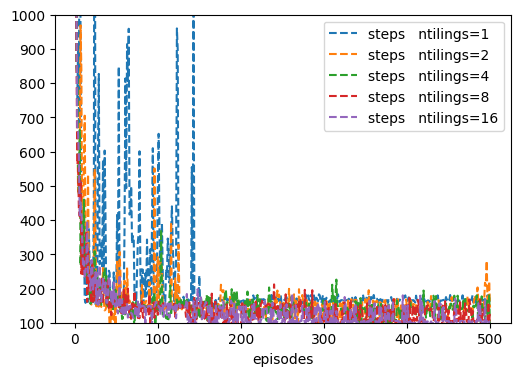

In [78]:
for n in trange(5):
    SarsaOnMountainCar(ntilings=2**n)

Note the difference between the max steps and the max steps when we did not use tile coding. We will demonstrate the  advantage of tile coding further in a more extensive experiments.

### Tiled coded mountain car runs
Let us see how the new tile coding behaves with respect to different learning rates, to do we simply call the SarsaMCar() function but we pass the tiledMountainCar environment with n=8.


100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


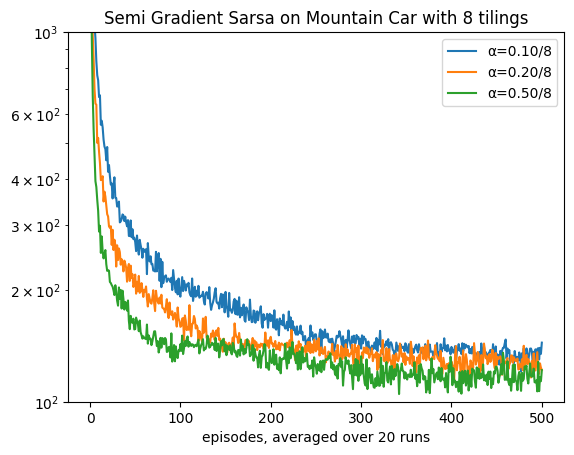

In [79]:
MountainCarRuns(env=tiledMountainCar(ntilings=8), ε=0, label='with 8 tilings')

Note that since we set  ε=0 and used optimistically initialisation, these settings made Sarsa closer to Q-learning in the sense that it is learning about a purely greedy policy (of course Q-learning is acting usually according to an exploratory policy  ε-greedy). Let us see how Q-learning behaves if we also set ε=0.

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


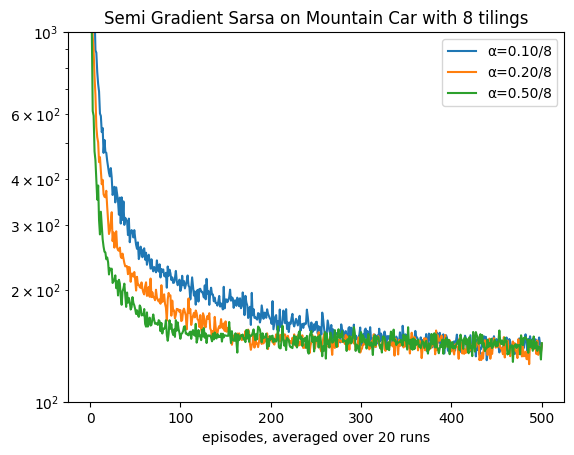

In [80]:
MountainCarRuns(env=tiledMountainCar(ntilings=8), ε=0.1, label='with 8 tilings')

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


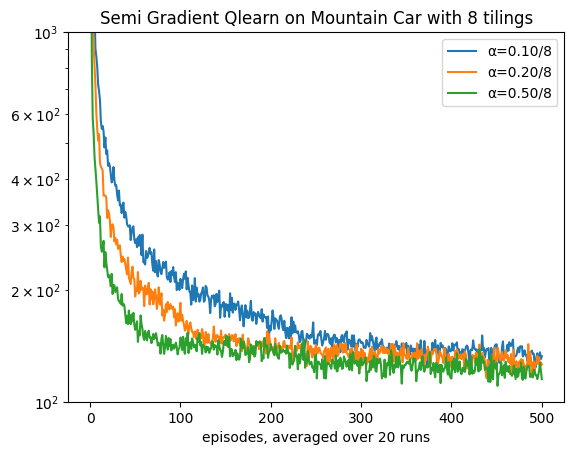

In [81]:
MountainCarRuns(algo=Qlearn, env=tiledMountainCar(ntilings=8), label='with 8 tilings')

Indeed as we can see .5/8 seems to be performing best for a additive one tile coding (the above class implemented one-hot coding which is a special case of tile coding where n=1). In the next section we implement a more generic state representation that allows for multiple tilings.

## Binary Tiled Mountain Car

In [82]:
class tiledMountainCarB(tiledMountainCar):
    def __init__(self, **kw): #ntilings: is number of tiles
        super().__init__(**kw)
    
    def s_(self):
        inds=[]
        s_tiling = self.s(self.ntilings)
        sv_tiling = self.sv(self.ntilings)

        for tiling in range(self.ntilings):
            s  = (s_tiling  + 1*tiling )//self.ntilings
            sv = (sv_tiling + 3*tiling )//self.ntilings
            ind = (tiling*self.dim[1] + s)*self.dim[2] + sv
            inds.append(ind)
            
        return inds


100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


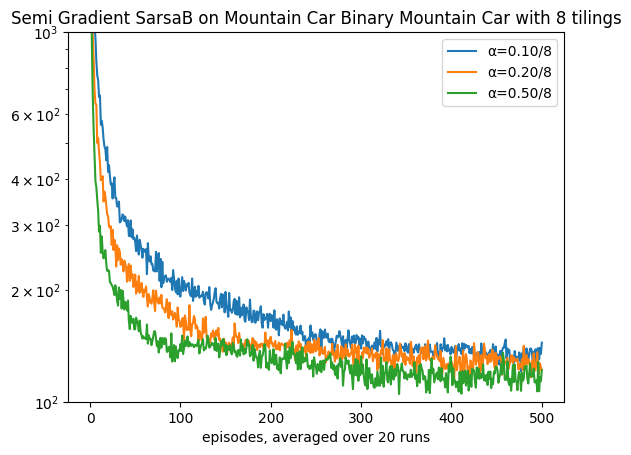

In [83]:
MountainCarRuns(algo=SarsaB, env=tiledMountainCarB(ntilings=8), label='Binary Mountain Car with 8 tilings')

As we can see again the performance is the same with an extra cost overhead in terms of time.

## Multiplicative State Space: *Hashed* Tile Coding for Mountain Car


This section draws on the idea of hashing a tile coding representation to reduce its dimensionality to make it more efficient. To solve the issues of high dimensionality when using multiple tilings, we can resort to the idea of *hashing*, which will help us to maintain a high resolution but reduce the space dimensionality. It does that by fixing the state space dimensionality regardless of the discretised space. 

It takes advantage of the fact that not all states will be visited as often, and when the agent starts exploring, the earlier states will be guaranteed to have unique encoding. Only later on, for less frequent states when the hashing table runs out of spaces, will there be some colliding (i.e. two states would have the same encoding). This violates a uniqueness of representation which is an explicit condition for several algorithms or similarity of representation for close states. However, such an effect is minimal compared to the benefits of redundancy of the original discretised space. The disadvantage can be ignored given that we made our table large enough.

Below we show a basic implementation of hashing. The idea is very simple; we hash the index of the feature that we were turning on in the tiledMountainCar class. In other words, we take the two indexes of position and velocity, along with the tiling index, and we hash the three indexes as a tuple. Then we apply the modulus % with the hash_size (same as the number of features) to obtain the index of the feature that we want it to be active. Note that the hashing function gives us some number that represents the tuple. We will get the same number each time we pass the same tuple. That is all that is being provided by the built-in hashing function. However, some different tuples might have the same modulus, which will cause collision even when the table size is larger than the state space. We will try to avoid this collision issue later. At least, we will minimise it so that it occurs only when the state space exceeds the table size.


In [84]:
class hashedtiledMountainCar(tiledMountainCar):
    def __init__(self, hash_size=1024,**kw): 
        super().__init__(**kw)
        self.nF = hash_size # fixed size that does not vary with the ntilings* ntiles
        
    def s_(self):
        φ = np.zeros(self.nF)
        for ind in self.inds():
            φ[hash(ind)%self.nF]=1
        return φ


CPU times: user 3.03 s, sys: 8.76 ms, total: 3.04 s
Wall time: 3.05 s


(100.0, 1000.0)

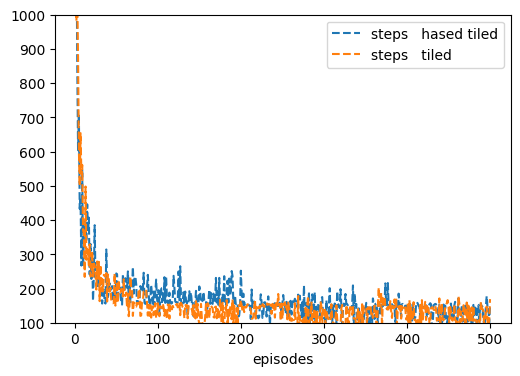

In [85]:
%time sarsa = Sarsa(env=hashedtiledMountainCar(ntilings=8, ntiles=8), α=.3/8, episodes=500, seed=1, ε=0, plotT=True).interact(label='hased tiled')
%time sarsa = Sarsa(env=      tiledMountainCar(ntilings=8, ntiles=8), α=.3/8, episodes=500, seed=1, ε=0, plotT=True).interact(label='tiled')

plt.gcf().set_size_inches(20,4)
plt.ylim(100,1000)

Note that there are some differences in the results of the last two steps graphs due to the issue of collisions that was discussed above.

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
CPU times: user 3min 26s, sys: 518 ms, total: 3min 26s
Wall time: 3min 27s


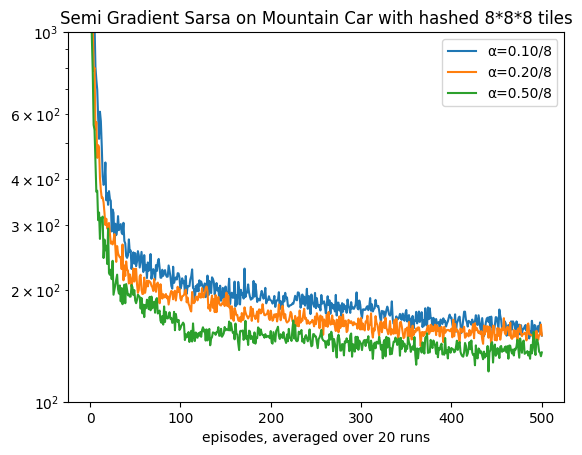

In [86]:
%time MountainCarRuns(env=hashedtiledMountainCar(ntilings=8, ntiles=8, hash_size=8*8*8), label='with hashed 8*8*8 tiles')

Let us reduce the hash table size (i.e. the number of features) used to represent *a state*. Once we have less representation power we expect deterioration in performance. Note that we still are dealing with 8x8x8 tiled coding we are reducing the capability of the hash table to accommodate all of the discretised states with no collision.

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
CPU times: user 4min 4s, sys: 821 ms, total: 4min 5s
Wall time: 4min 6s


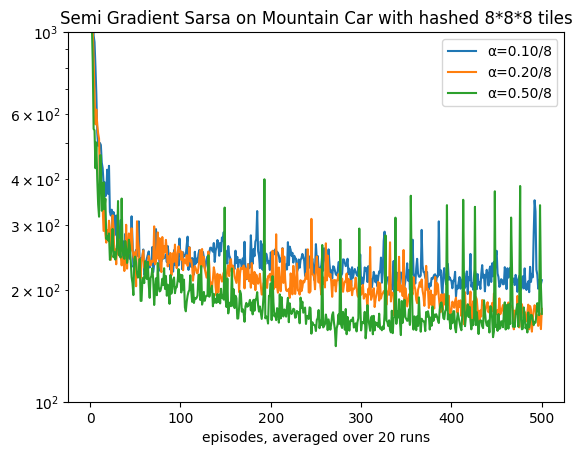

In [87]:
%time MountainCarRuns(env=hashedtiledMountainCar(ntilings=8, ntiles=8, hash_size=8*8*4), label='with hashed 8*8*8 tiles')

As we can see the performance of the model deteriorated a bit when we reduced the hash table size due to collision.

## Index Hashed Table (IHT)
Directly using the hash function on upcoming tuples of indexes is fine, but it loses an opportunity to store nearby states in nearby locations and to guarantee consistency in allowing for collision. A collision occurs when two tuples have the same index values. This means that two states will have the same representation, and the uniqueness of representation is violated. This can be a last resort for a very large state space, but it is better not to for small to medium spaces. 

The index hash table allows us to store the tuples as values (in a dictionary) and their indices as keys. Thanks to the dictionary structure in Python, we can retrieve the index of a tuple at any point with O(1) cost to do. What is left is then to only resort to hashing a key when we cannot store it anymore in the table, and in this case, we need to live with collision. Below we show a simplified and more concise implementation. For more details, refer to [hash tile coding](http://incompleteideas.net/tiles/tiles3.py-remove), described in our textbook. We built our code differently to avoid storing the indices explicitly in a table for more efficiency. The standard software has extra capabilities we do not need here (ex. adding the action index is unnecessary since we do not amalgamate all the weights of different actions in one large weight vector).

In [88]:
class IHTtiledMountainCar(tiledMountainCar):
    def __init__(self, iht_size=1024, **kw): # by default we have 8*8*8 (position tiles * velocity tiles * tilings)
        super().__init__(**kw)
        self.nF = iht_size

    def s_(self):
        φ = np.zeros(self.nF)
        inds = np.where(super().s_()!=0)[0]
        φ[inds%self.nF]=1
        return φ


In [89]:
10*11*8

880

CPU times: user 2.93 s, sys: 3.14 ms, total: 2.93 s
Wall time: 2.93 s


(100.0, 1000.0)

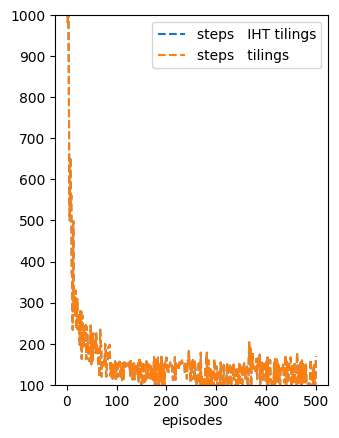

In [90]:
%time sarsa = Sarsa(env=IHTtiledMountainCar(ntilings=8, ntiles=8), \
                α=.3/8, episodes=500, seed=1, ε=0, plotT=True).interact(label='IHT tilings')

%time sarsa = Sarsa(env=tiledMountainCar(ntilings=8, ntiles=8), \
                α=.3/8, episodes=500, seed=1, ε=0, plotT=True).interact(label='tilings')

# %time sarsa = Sarsa(env=hashedtiledMountainCar(ntilings=8, ntiles=8), α=.3/8, episodes=500, seed=1, ε=0, plotT=True).interact(label='hashed tilings')

plt.ylim(100, 1000)

Note how the two graphs are identical, although we have used an index hashing table (IHT) in the second while we did not in the first. This is because IHT maps the indices of the visited states, and unless the number of states exceeds the IHT size, the results will be identical to those with no hashing. This is the major advantage of IHT over just hashing. The downside is that it can be computationally more expensive to use IHT, so the equivalence is with an overhead cost. However, in our implementation, we have avoided this overhead completely!

100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10
100%|██████████████████████████████████████████████████████████████████████████████████████████|10/10


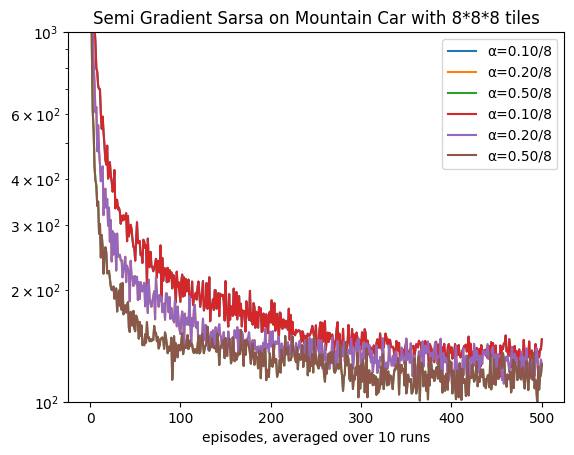

In [91]:
MountainCarRuns(runs=10, env=IHTtiledMountainCar(ntilings=8,ntiles=8), label='with index hashed table for 8*8*8 tiles')
MountainCarRuns(runs=10, env=   tiledMountainCar(ntilings=8,ntiles=8), label='with 8*8*8 tiles')

### Collisions in a Hash Representation
Note that the actual state dimension is tiles *$\times$ tiles  $\times$ number of tilings*: since we have the 8 tiles for the positions and 8 for the velocity (8 by 8 grid) and 8 tilings:

In [92]:
8*8*8

512

So we could get away with 512 without collision in the hash table. Collision occurs whenever we use the same key for more than one state. We scarify some accuracy due this collision. So unless it is necessary we try to avoid it by being generous in the memory allocation for the hash table (same as our feature vector). We may allow  some collision for larger space on the base that important states will be visited more often and hence their representation will overshadow other less frequent states.

## Tilings Comparison
In this section we compare between the performance of Sarsa on different tilings to see the effect of changing the power of state representation.

In [93]:
def MountainCarTilings(runs=20, α=.3, algo=Sarsa, env=tiledMountainCar):
    
    plt.title('Sarsa on mountain car: comparison of different tilings with α=%.2f/8'%α)
    for ntilings in [2, 4, 8, 16, 32]:
        sarsaRuns = Runs(algorithm=algo(env=env(ntiles=8, ntilings=ntilings),α=α/ntilings,episodes=500, ε=0), 
                         runs=runs, seed=1, plotT=True).interact(label='%d tilings'%ntilings)
    plt.ylim((10**2,10**3))
    plt.yscale('log')
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


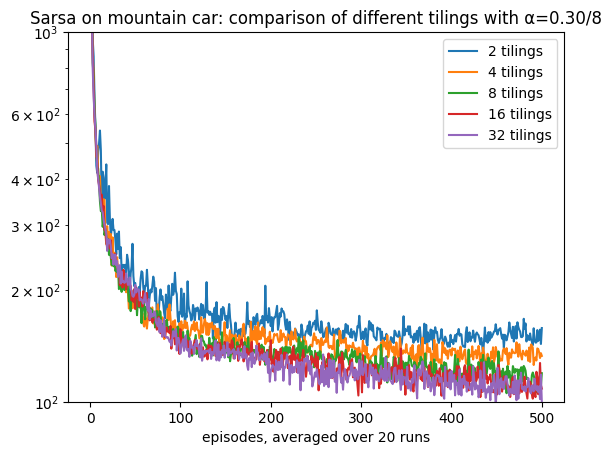

In [94]:
MountainCarTilings()

## Comparing n-Step Sarsa on Mountain Car with different  α
Let us compare systematically how different number of steps plays with the learning rate α for the mountain car problem. We will use hashed tilings with 8 tiles and 8 tilings. The goal is to confirm whether the behaviour of n-step Sarsa for control is compatible with the behaviour of n-step TD for prediction. 

Below we show the implementation of n-step Sarsa with function approximation. It is identical to the tabular form except we use the function Q(sn,an) instead of Q[sn,an].

In [95]:
class Sarsan(vMDP):

    def init(self):
        super().init()
        self.store = True        # although online but we need to access *some* of earlier steps,
        self.step = self.step_an # for Sarsa we want to decide the next action in time step t

    # ----------------------------- 🌖 online learning ----------------------    
    def online(self, *args):
        τ = self.t - (self.n-1);  n=self.n
        if τ<0: return
        
        # we take the min so that we do not exceed the episode limit (last step+1)
        τ1 = τ+1
        τn = τ+n ; τn=min(τn, self.t+1 - self.skipstep)
        
        sτ = self.s[τ];  aτ = self.a[τ]
        sn = self.s[τn]; an = self.a[τn]
        done = self.done[τn]
        
        # n steps τ+1,..., τ+n inclusive of both ends
        self.W[aτ] += self.α*(self.G(τ1,τn) + (1-done)*self.γ**n *self.Q(sn,an) - self.Q(sτ,aτ))*self.ΔQ(sτ)

Below we see that the an intermediate n (number of steps in n-step Sarsa) acts best in similar to the effect of the number of steps on random walk and that control algorithms with intermediate bootstrapping usually performs best.

In [96]:
def MountainCarTiledRuns_n(runs=20, algo=Sarsan, env=tiledMountainCar):
    
    plt.title(algo.__name__+' on mountain car: comparison of n-steps with the same 8x8x8 tilings')
    for n, α in zip([1, 8], [.5, .3]):
        sarsaRuns = Runs(algorithm=algo(env=env(ntiles=8, ntilings=8), n=n, α=α/8,episodes=500, ε=0), 
                         runs=runs, seed=1, plotT=True).interact(label='%d step-Sarsa, α=%.2f/8'%(n,α))
    plt.ylim((10**2,10**3))
    plt.yscale('log')
    plt.show()
figure_10_3_n = MountainCarTiledRuns_n

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


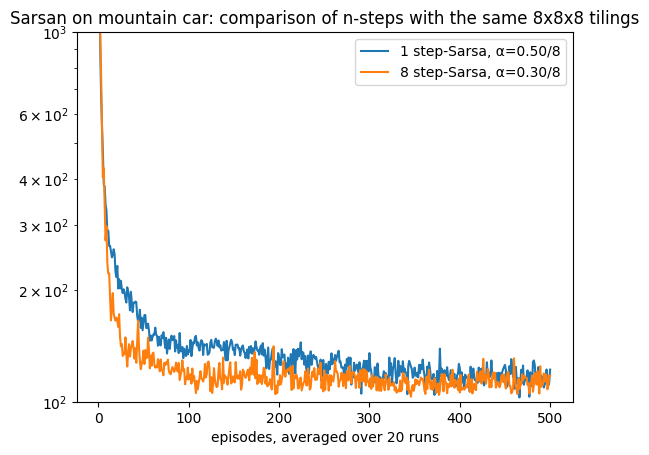

CPU times: user 2min 1s, sys: 231 ms, total: 2min 1s
Wall time: 2min 1s


In [97]:
%time figure_10_3_n(env=tiledMountainCar)

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


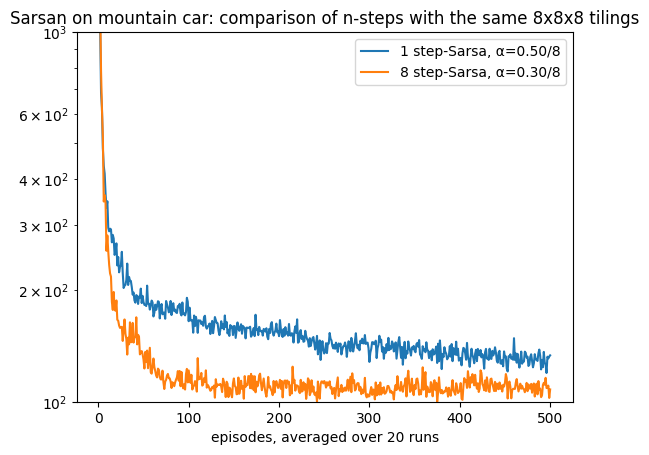

CPU times: user 2min 10s, sys: 249 ms, total: 2min 11s
Wall time: 2min 11s


In [98]:
%time figure_10_3_n(env=hashedtiledMountainCar)

100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20
100%|██████████████████████████████████████████████████████████████████████████████████████████|20/20


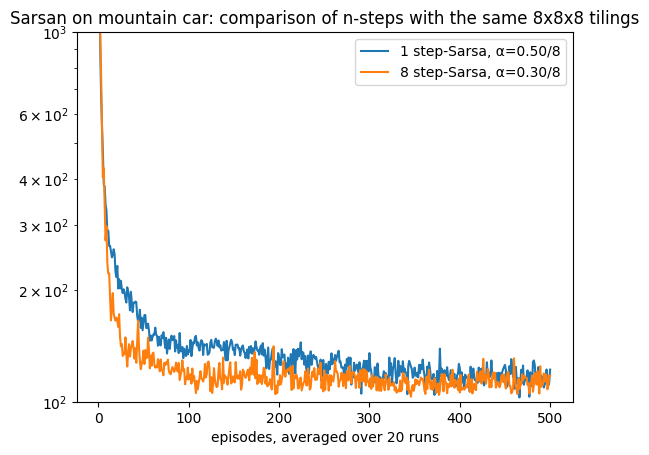

CPU times: user 2min 28s, sys: 270 ms, total: 2min 28s
Wall time: 2min 28s


In [99]:
%time figure_10_3_n(env=IHTtiledMountainCar)

As we can see the IHT performed exactly the same as the tiledMountainCar representation since we are using a large enough table_size, it gave a boost to the one-step Sarsa to become closer to the 8-step Sarsa.

### Model Selection for n_step Sarsa
In this section we conduct an extensive set of experiments on Mountain Car with different learning rates in a similar manner to the study that we conducted for TD with random walk problem.


In [100]:
def MountainCarTiledCompare_n(runs=5, ntilings=8,  env=IHTtiledMountainCar): # 10
    
    xsticks = np.array([0, .5 , 1, 1.5, 2, 2.3])/ntilings
    plt.xticks(ticks=xsticks, labels=xsticks*ntilings)
    plt.yticks([220, 240, 260, 280, 300])
    plt.ylim(210, 300)
    plt.title('Steps per episode averaged over first 50 episodes')

    for n in range(5):
        if n==0: αs = np.arange(.4,  1.8,  .1)
        if n==1: αs = np.arange(.2,  1.8,  .1)
        if n==2: αs = np.arange(.1,  1.8,  .1)
        if n==3: αs = np.arange(.1,  1.2,  .07)
        if n==4: αs = np.arange(.1,  1.0,  .07)
    
        Compare(algorithm=Sarsan(env=env(ntiles=8, ntilings=ntilings), n=2**n, episodes=50, ε=0), runs=runs, 
                                  hyper={'α':αs/ntilings}, 
                                  plotT=True).compare(label='%d-step Sarsa'%2**n)
    plt.xlabel(r'$\alpha \times 8$ since we used 8 tiles for each tilings')
    plt.show()
    

figure_10_4_n = MountainCarTiledCompare_n

Note that we always divided the learning rates αs by ntilings to match the amount of changes for different number of tilings so that we end up with an update magnitude that is compatible with a one-hot encoding.

100%|██████████████████████████████████████████████████████████████████████████████████████████|14/14
100%|██████████████████████████████████████████████████████████████████████████████████████████|16/16
100%|██████████████████████████████████████████████████████████████████████████████████████████|17/17
100%|██████████████████████████████████████████████████████████████████████████████████████████|16/16
100%|██████████████████████████████████████████████████████████████████████████████████████████|13/13


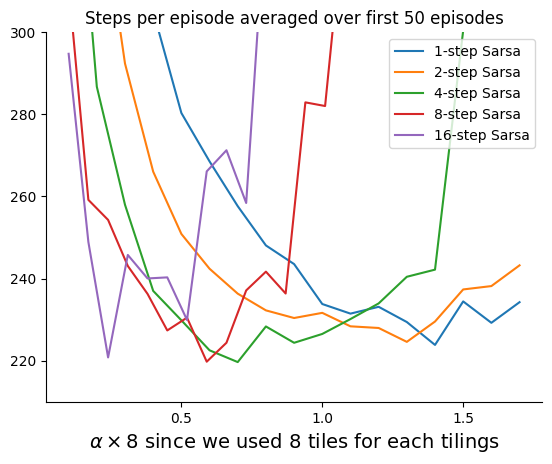

CPU times: user 4min 51s, sys: 588 ms, total: 4min 52s
Wall time: 4min 52s


In [101]:
%time MountainCarTiledCompare_n()

Note that we have not used hashing and hence our range is different from the one stated in the book. Nevertheless, the pattern is maintained.

## Conclusion
In this lesson, you saw how to deal with a continuous state space using function approximation and how to apply previous concepts to a more difficult control problem. We saw how to apply the tile coding technique we covered in the previous lesson on a continuous *control* Mountain car task. Along the way, we developed a new binary algorithm, Binary Sarsa, that is suitable for dealing with binary encoding, and we will study its performance. We present three representations of the problem. The first just discretised the space and used a vector representation that corresponds with this discretisation. This representation is equivalent to using one tiling in tile coding. Then we developed this representation to use multiple tiling that offset each other to enrich the representation capability for our continuous space. We then reduced the extra overhead introduced by the tile coding using hashing. We show that hashing is a powerful technique, and we studied a simple and efficient implementation of it. We concluded by updating our Sarsa(n) algorithm and applying it to the mountain car to compare its performance with different n. In the next lesson, we will show a new set of algorithms that achieve a similar or better performance without waiting for n steps.

## Your turn
1. run the MountainCarTilings but this time fixed the divider on 8 (instead of dividing by ntilings), observe the results and compare them to the original experiments, post what you can infer in the group discussion.



## Challenge
1. Implement a state rep that directly use the software library provided by the book [here]((http://incompleteideas.net/tiles/tiles3.py-remove)).
1. Can you think of a way to make the Mountain Car class works for the tabular case(assume that we have one tiling )

[Back to TOC](IntroductionTOC.ipynb)